This is an adaptation of the [Holt-Winters with Python](https://docs.timescale.com/latest/tutorials/tutorial-forecasting#tutorial-python) example for TimescaleDB using the [Prometheus SQL adapter](https://github.com/ssube/prometheus-sql-adapter) schema as a data source.

In [1]:
import matplotlib.pyplot as plot
import numpy as np
import os
import pandas as pd
import pandas.io.json as pj
import psycopg2
from statsmodels.tsa.api import ExponentialSmoothing

In [7]:
conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
samples = pd.read_sql_query("""
SELECT 
    s.bucket AS time, 
    MAX(s.max_load) AS value, 
    REGEXP_REPLACE(l.labels->>'instance', '\d+\.\d+\.\d+\.', 'xxx.yyy.zzz.') AS instance 
FROM agg_instance_load AS s
JOIN metric_labels AS l 
    ON s.lid = l.lid
WHERE s.bucket > NOW() - INTERVAL '14 days'
GROUP BY s.bucket, instance
ORDER BY s.bucket, instance
""", conn)
conn.close()

In [8]:
print(samples.head(5))

                 time  value              instance
0 2019-12-10 12:00:00   1.65  xxx.yyy.zzz.158:9100
1 2019-12-10 12:00:00   1.57  xxx.yyy.zzz.163:9100
2 2019-12-10 12:00:00   0.39  xxx.yyy.zzz.164:9100
3 2019-12-10 12:00:00   1.19  xxx.yyy.zzz.180:9100
4 2019-12-10 12:00:00   0.51  xxx.yyy.zzz.192:9100


In [9]:
nodes = samples[['instance']].replace(r':\d+', '', regex=True)
load = samples.drop(columns=['instance']).join(nodes)

In [10]:
print(load.head(5))

                 time  value         instance
0 2019-12-10 12:00:00   1.65  xxx.yyy.zzz.158
1 2019-12-10 12:00:00   1.57  xxx.yyy.zzz.163
2 2019-12-10 12:00:00   0.39  xxx.yyy.zzz.164
3 2019-12-10 12:00:00   1.19  xxx.yyy.zzz.180
4 2019-12-10 12:00:00   0.51  xxx.yyy.zzz.192


In [11]:
iload = load.groupby(['instance'])
print(iload.describe())

                  value                                                    
                  count      mean       std   min   25%   50%    75%    max
instance                                                                   
xxx.yyy.zzz.158  3743.0  0.667034  0.513207  0.02  0.29  0.56  0.930   7.97
xxx.yyy.zzz.163  3743.0  1.670983  0.616624  0.31  1.23  1.61  2.040   4.41
xxx.yyy.zzz.164  3744.0  0.758216  0.412653  0.01  0.46  0.67  0.940   2.85
xxx.yyy.zzz.180  3743.0  1.028734  0.930174  0.09  0.49  0.79  1.210  10.08
xxx.yyy.zzz.192  3743.0  0.828707  0.411762  0.10  0.51  0.76  1.085   2.80
xxx.yyy.zzz.236  3744.0  0.544923  0.264275  0.09  0.36  0.47  0.670   2.53
xxx.yyy.zzz.59   3743.0  1.011942  1.593910  0.05  0.36  0.58  0.970  16.53
xxx.yyy.zzz.77   3743.0  0.802864  0.503736  0.06  0.46  0.73  1.040   7.34
xxx.yyy.zzz.99   3744.0  0.851878  0.432400  0.09  0.55  0.75  1.040   3.11


In [14]:
tload = pd.pivot(load, index='time', columns='instance', values='value').resample('1h').max()
print(tload.head(2))

instance             xxx.yyy.zzz.158  xxx.yyy.zzz.163  xxx.yyy.zzz.164  \
time                                                                     
2019-12-10 12:00:00             1.65             3.58             1.75   
2019-12-10 13:00:00             1.37             3.53             1.48   

instance             xxx.yyy.zzz.180  xxx.yyy.zzz.192  xxx.yyy.zzz.236  \
time                                                                     
2019-12-10 12:00:00             1.19             0.89             1.29   
2019-12-10 13:00:00             1.28             2.12             1.02   

instance             xxx.yyy.zzz.59  xxx.yyy.zzz.77  xxx.yyy.zzz.99  
time                                                                 
2019-12-10 12:00:00            0.61            0.81            2.40  
2019-12-10 13:00:00            1.15            1.31            2.14  


Disable numpy warnings. This is not normally a good idea, but ExponentialSmoothing shows a large warning banner when it cannot converge.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Fitting trends for xxx.yyy.zzz.158... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.158
Fitting trends for xxx.yyy.zzz.163... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.163
Fitting trends for xxx.yyy.zzz.164... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.164
Fitting trends for xxx.yyy.zzz.180... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.180
Fitting trends for xxx.yyy.zzz.192... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 hours; 28 hours; 32 hours; 36 hours; 40 hours; 44 hours; 48 hours; 
Plotting xxx.yyy.zzz.192
Fitting trends for xxx.yyy.zzz.236... 4 hours; 8 hours; 12 hours; 16 hours; 20 hours; 24 h

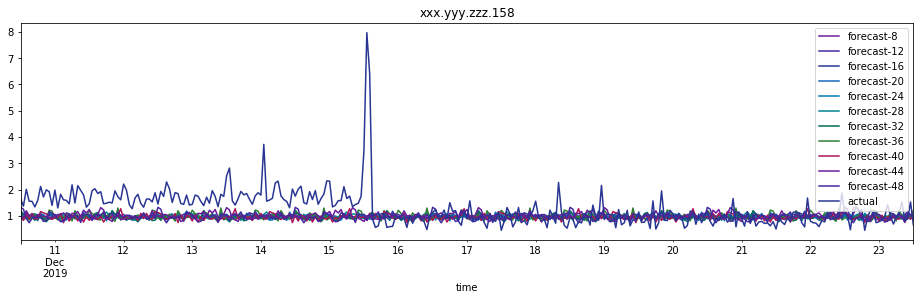

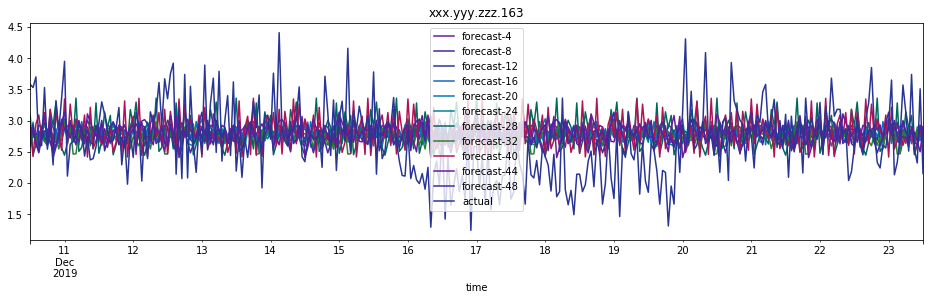

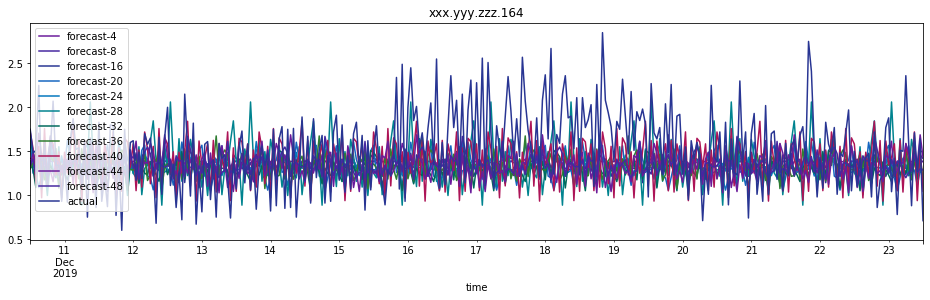

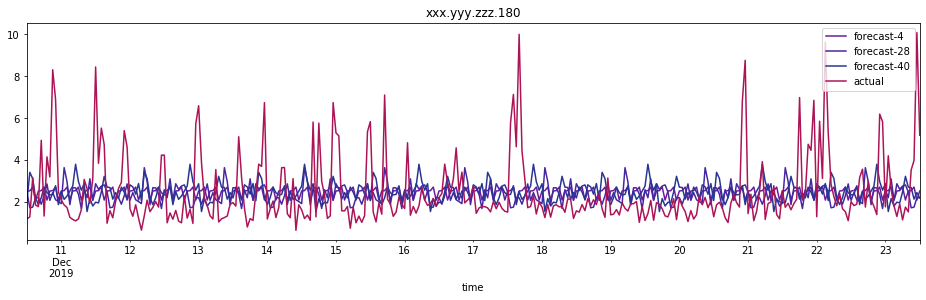

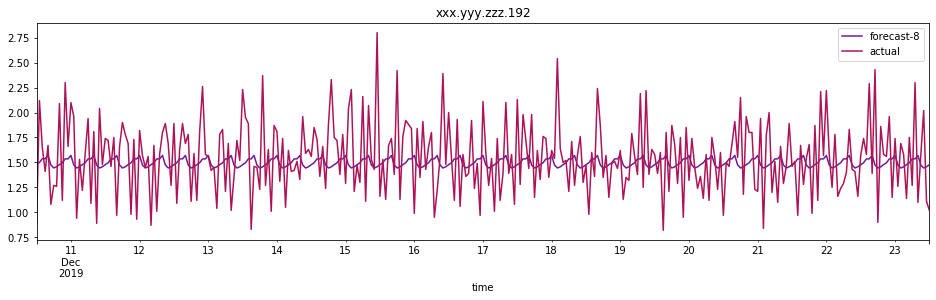

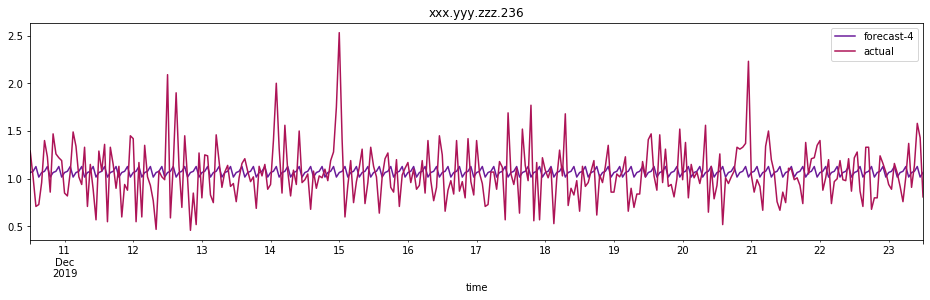

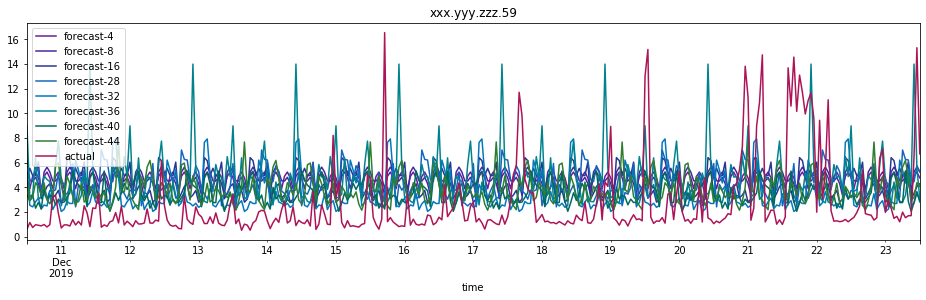

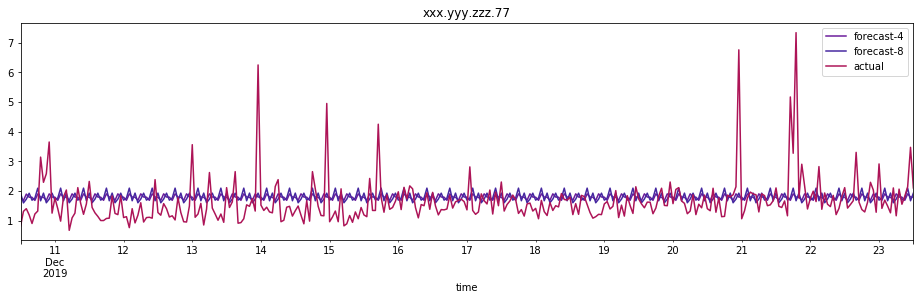

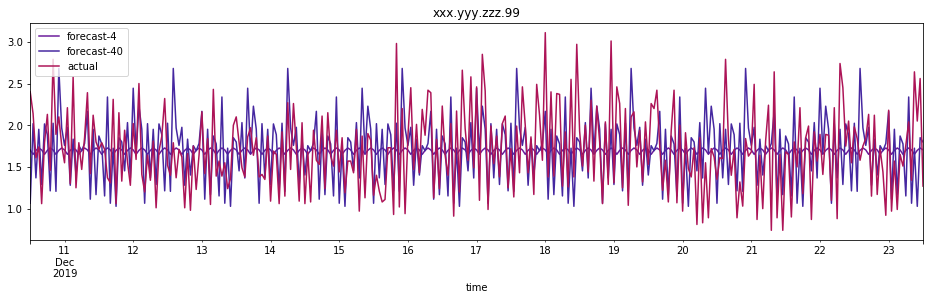

In [17]:
%matplotlib inline

palette_fit = [
    '#6a1b9a', '#4527a0', '#283593', '#1565c0',
    '#0277bd', '#00838f', '#00695c', '#2e7d32'
]
palette_key = '#ad1457'

period_hour = 4
period_num = 12

tf = pd.DataFrame(data=tload, copy=True)
for row in tf:
    fload = tf[row]
    vals = np.array(fload.to_numpy(np.float64).flat)
    
    print(f'Fitting trends for {fload.name}...', end=' ')
    fss = []
    for period in np.linspace(period_hour, period_hour * period_num, period_num):
        try:
            ip = int(period)
            print(f'{ip} hours;', end=' ')
            fit = ExponentialSmoothing(
                vals, trend='add', seasonal='add', seasonal_periods=ip, damped=True
            ).fit(use_boxcox=True)
            forecast = fit.forecast(len(fload))
            
            if not np.isnan(forecast[0]):
                fs = pd.Series(forecast, name=f'forecast-{ip}', index=fload.index)
                fss.append(fs)
        except:
            print(f'error fitting {row} at {period} hour period')
    
    print()
    print(f'Plotting {fload.name}')
    
    colors = palette_fit[0:len(fss)]
    colors.append(palette_key)
    
    overall = pd.concat([*fss, fload], axis=1).rename(columns={fload.name: "actual"})    
    overall.plot.line(title=fload.name, color=colors, figsize=(16, 4))